In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from decision_trees.config import data_path
from decision_trees.plotting_utils import *

sns.set_context("talk")

# settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load In Data

Load in data (cleaned if was necessary)

In [13]:
fpath = "processed/breast_cancer.csv"
df = pd.read_csv(data_path / fpath)
df.head()

,age,race,marital_status,t_stage,n_stage,stage,differentiate,grade,a_stage,tumor_size,...,survival_months,status,t_stage_num,n_stage_num,stage_num,has_estrogen,has_progesterone,is_alive,is_metastasized,regional_node_frac_positive
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,...,60,Alive,1,1,1,True,True,True,False,0.0417
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,...,62,Alive,2,2,3,True,True,True,False,0.3571
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,...,75,Alive,3,3,5,True,True,True,False,0.5000
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,...,84,Alive,1,1,1,True,True,True,False,0.5000
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,...,50,Alive,2,1,2,True,True,True,False,0.3333


## 2. Describe data

Things to consider:
* datatypes: cat, float, int, datetime
* distributions of numerical data ~ predictor
* multi-variate distributions 

https://ieee-dataport.org/open-access/seer-breast-cancer-data

more info on 6th edition stages: https://seer.cancer.gov/seerstat/variables/seer/ajcc-stage/6th/

Columns:
* 'Age': age of px at dx,

* 'Race': White, Black, Other, Other-Unspecified, Unknown (Other=Asian, Pacific Islander, American Indian)

* 'Marital Status': Single, Married, Separated, Divorced, Widowed. at time of dx,

* 'T Stage': size and extent of the main tumor (bigger is worse). T1-T4,

* 'N Stage': number of nearby affected lymph nodes. N1-N3,

* '6th Stage': what stage of cancer - 6th edition stage of cancer, increases from IIA->IIB->IIIA->IIIB->IIIC,

* 'differentiate': range from Well->Moderate->Poorly->Undifferentiated, where undifferentiated is the worst,

* 'Grade': range from 1-4 (numerical encoding of "differentiate" column),

* 'A Stage': Regional or Distant. Distant means more metastasized (worse),

* 'Tumor Size': exact size in mm,

* 'Estrogen Status': if the tumor is Positive or Negative for estrogen receptors (if cancer cells are estrogen positive, it means it has receptors for estrogen, meaning estrogen levels affect the growth of the tumor. determining which receptor type you're positive for (estrogen and/or progesterone) determines what treatment options you have),

* 'Progesterone Status': Positive or Negative to progesterone receptors, same concept as estrogen,

* 'Regional Node Examined': total number of regional lymph nodes that were removed and examined by the pathologist,

* 'Regional Node Positive': total number of regional lymph nodes that were examined and found to be positive,

* 'Survival Months': amount of time px has survived since dx (if px is alive, this number is the min number of months they've survived, could be longer),

* 'Status': Alive or Dead

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          4024 non-null   int64  
 1   race                         4024 non-null   object 
 2   marital_status               4024 non-null   object 
 3   t_stage                      4024 non-null   object 
 4   n_stage                      4024 non-null   object 
 5   stage                        4024 non-null   object 
 6   differentiate                4024 non-null   object 
 7   grade                        4024 non-null   object 
 8   a_stage                      4024 non-null   object 
 9   tumor_size                   4024 non-null   int64  
 10  estrogen_status              4024 non-null   object 
 11  progesterone_status          4024 non-null   object 
 12  regional_node_examined       4024 non-null   int64  
 13  regional_node_posi

## 3. Plot Data

[X] Correlation analysis/heatmap of numerical variables 

[X] Pair plot, hue on survival status

[X] Bi-variate plots ~ survival (e.g. n stage versus t stage colored by survival)

[ ] Distribution of survival months ~ survival status

[ ] P(survive) ~ survival months

[ ] Decide if we need to truncate is_alive depending on month


### Correlation

<Axes: >

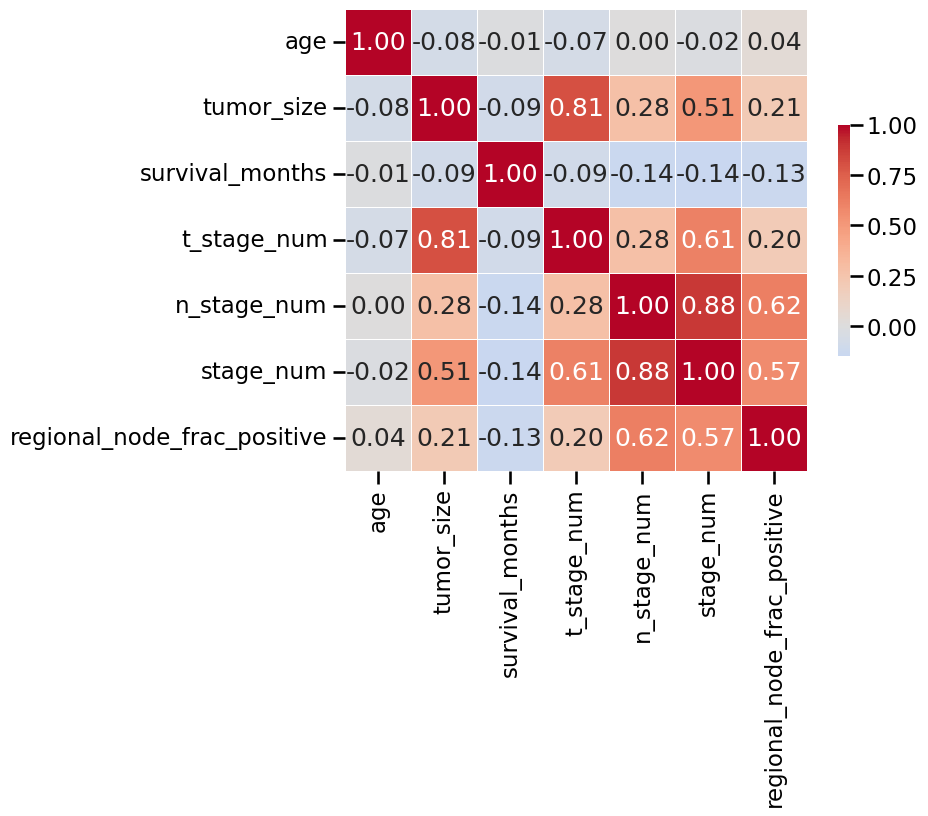

In [34]:
numeric_vars = [
    "age",
    "tumor_size",
    "survival_months",
    "t_stage_num",
    "n_stage_num",
    "stage_num",
    "regional_node_frac_positive",
]

corr = df[numeric_vars].corr()

ax = mf((8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    center=0,
)

**Correlation Plot Notes**: 
* Most variables are positively correlated with each other
* N stage num is highly correlated with stage number. Perhaps number of infected lymph nodes (or extent of spread) is used to determine the stage number
* N stage num is highly correlated with fraction of regional nodes positive. This makes sense given they are somewhat overlapping measures.
* T stage num is highly correlated with tumor size and this makes sense since they are overlapping metrics of tumor extent. 
* T stage num and tumor size are highly correlated with stage number. Again, perhaps size of the main tumor influences stage number diagnosis.
* Age and survival months do not seem to have any correlation with the other variables


Vars I'd be worried about for correlation/double dipping
* tumor size & t stage num
* stage num & n stage num & metastasized
* n stage num & frac regional positive & is metastasized

#### Correlation Follow Up

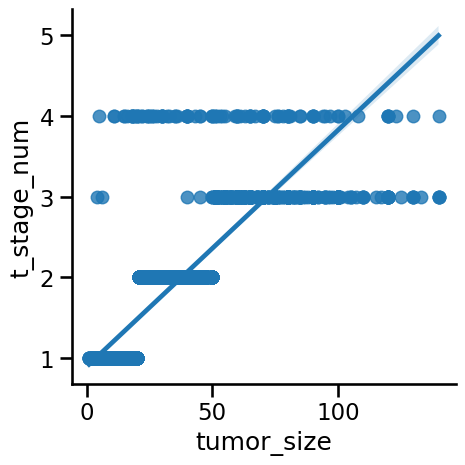

In [38]:
sns.lmplot(data=df, x="tumor_size", y="t_stage_num")

In [42]:
df.columns

Index(['age', 'race', 'marital_status', 't_stage', 'n_stage', 'stage',
       'differentiate', 'grade', 'a_stage', 'tumor_size', 'estrogen_status',
       'progesterone_status', 'regional_node_examined',
       'regional_node_positive', 'survival_months', 'status', 't_stage_num',
       'n_stage_num', 'stage_num', 'has_estrogen', 'has_progesterone',
       'is_alive', 'is_metastasized', 'regional_node_frac_positive'],
      dtype='object')

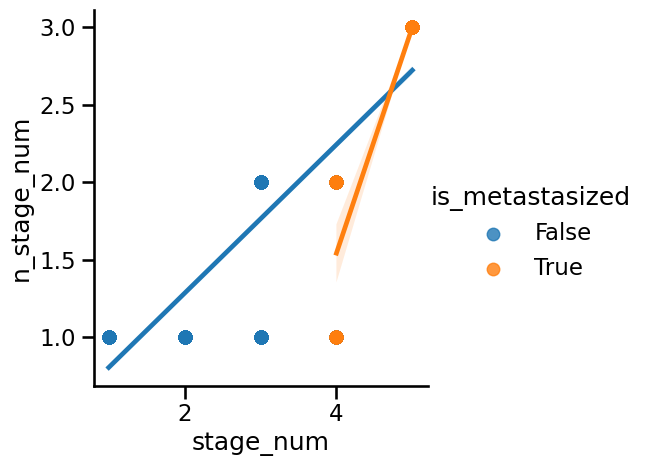

In [43]:
sns.lmplot(data=df, x="stage_num", y="n_stage_num", hue="is_metastasized")

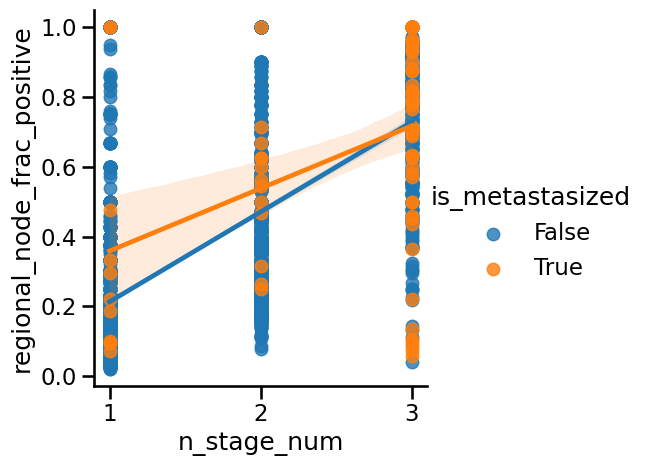

In [46]:
sns.lmplot(
    data=df, x="n_stage_num", y="regional_node_frac_positive", hue="is_metastasized"
)

**Summary Thoughts**: 
* for the highest t stage num (4), tumor size does not appear to be correlated. or at least this relationship isn't fully linear (plot 1)
* it does appear that n stage num, stage num and is metast. carry overlapping information (plot 2)
* n stage num and regional node positive frac are positively correlated and overlapping, is metast. does not add to this (plot 3)

In [7]:
duplicate_cols = [
    "has_progesterone",
    "has_estrogen",
    "is_metastasized",
    "is_alive",
    "regional_node_examined",
    "regional_node_positive",
]



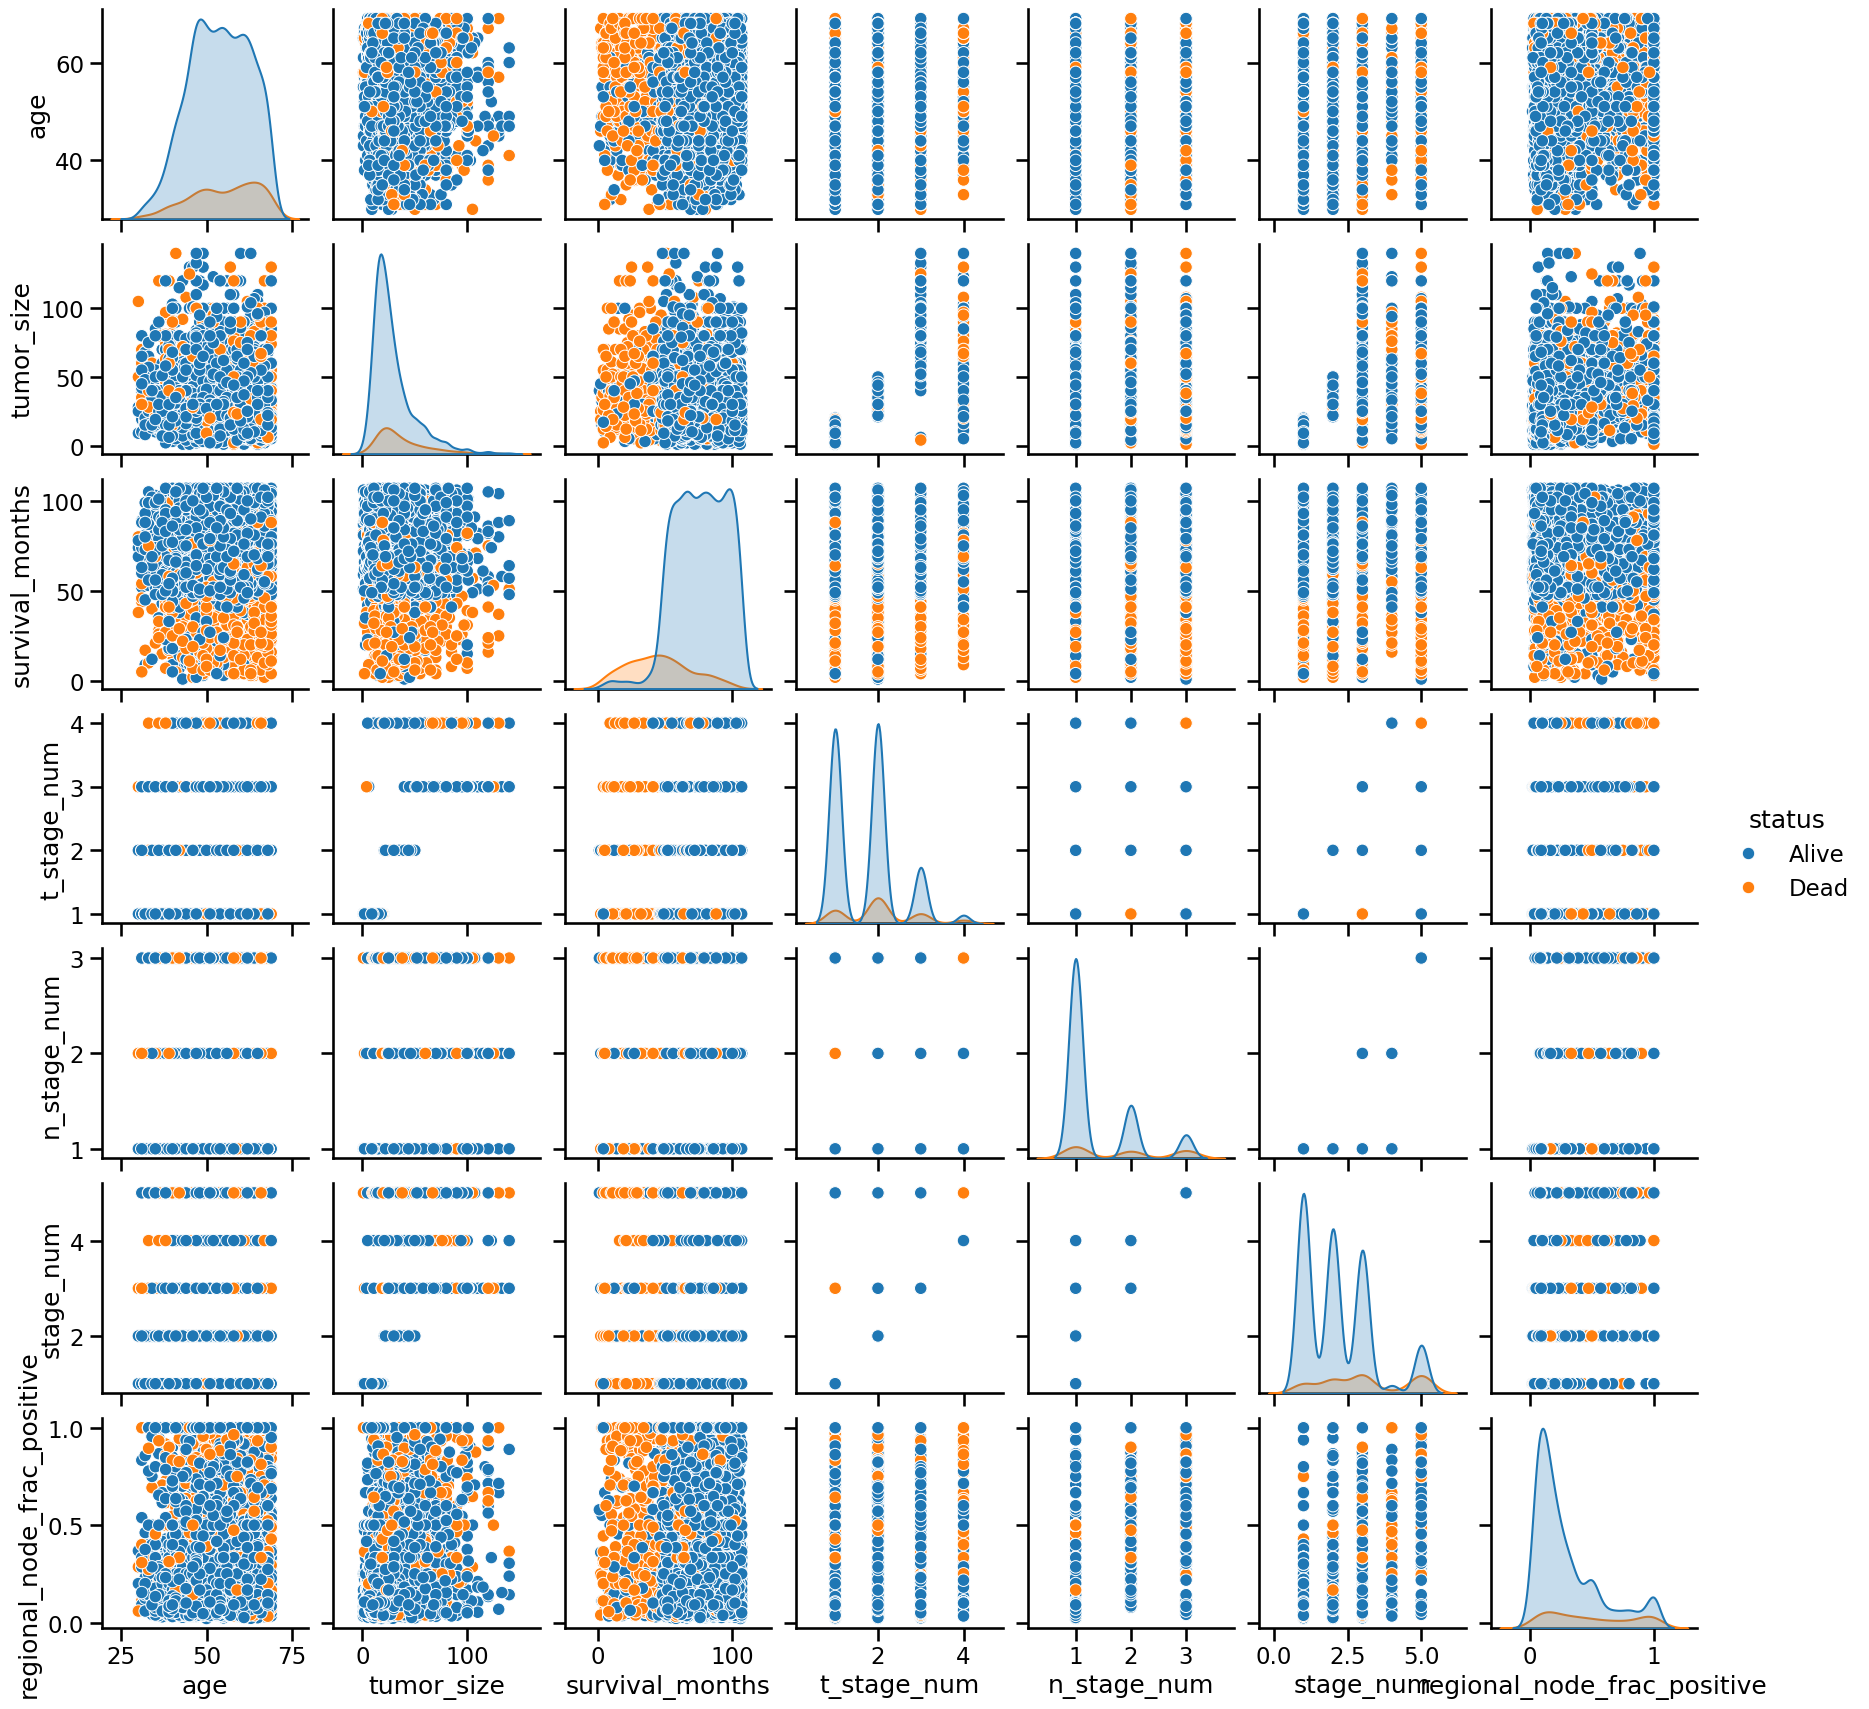

In [35]:
sns.pairplot(
    df.drop(columns=duplicate_cols),
    hue="status",
)

**Pair Plot Notes:**
* surivial months seems to be a very infleuntial var for splitting between dead and alive
* ordinal plots need to be jittered or heatmapped for better understaning (e.g. nstage num)
* the higher stage numbers have lower density.
* regional node frac positive is more rightward skeweed for alive and bimodel for dead.


In [47]:
def jitter_plot(df, x_col, y_col, hue_col="status", jitter_amount=0.4, ax=None):
    """
    quick fx for jitter scatter plot
    """
    if ax is None:
        ax = mf((8, 6))

    x_jittered = df[x_col] + np.random.uniform(-jitter_amount, jitter_amount, len(df))
    y_jittered = df[y_col] + np.random.uniform(-jitter_amount, jitter_amount, len(df))

    # Create a scatter plot with jittered data
    sns.scatterplot(x=x_jittered, y=y_jittered, hue=df[hue_col], alpha=0.5, ax=ax)

    ax.legend(bbox_to_anchor=(1.05, 1))

    return None

In [49]:
def pivot_to_heat_map(df, columns, index, values="is_alive", margins=True, ax=None):
    if ax is None:
        ax = mf((6, 5))

    pivot = df.pivot_table(
        columns=columns,
        index=index,
        values=values,
        aggfunc="mean",
        margins=margins,
    )

    sns.heatmap(pivot, cmap="rocket", ax=ax)

    return None

('t_stage_num', 'n_stage_num')
('stage_num', 't_stage_num')
('stage_num', 'n_stage_num')


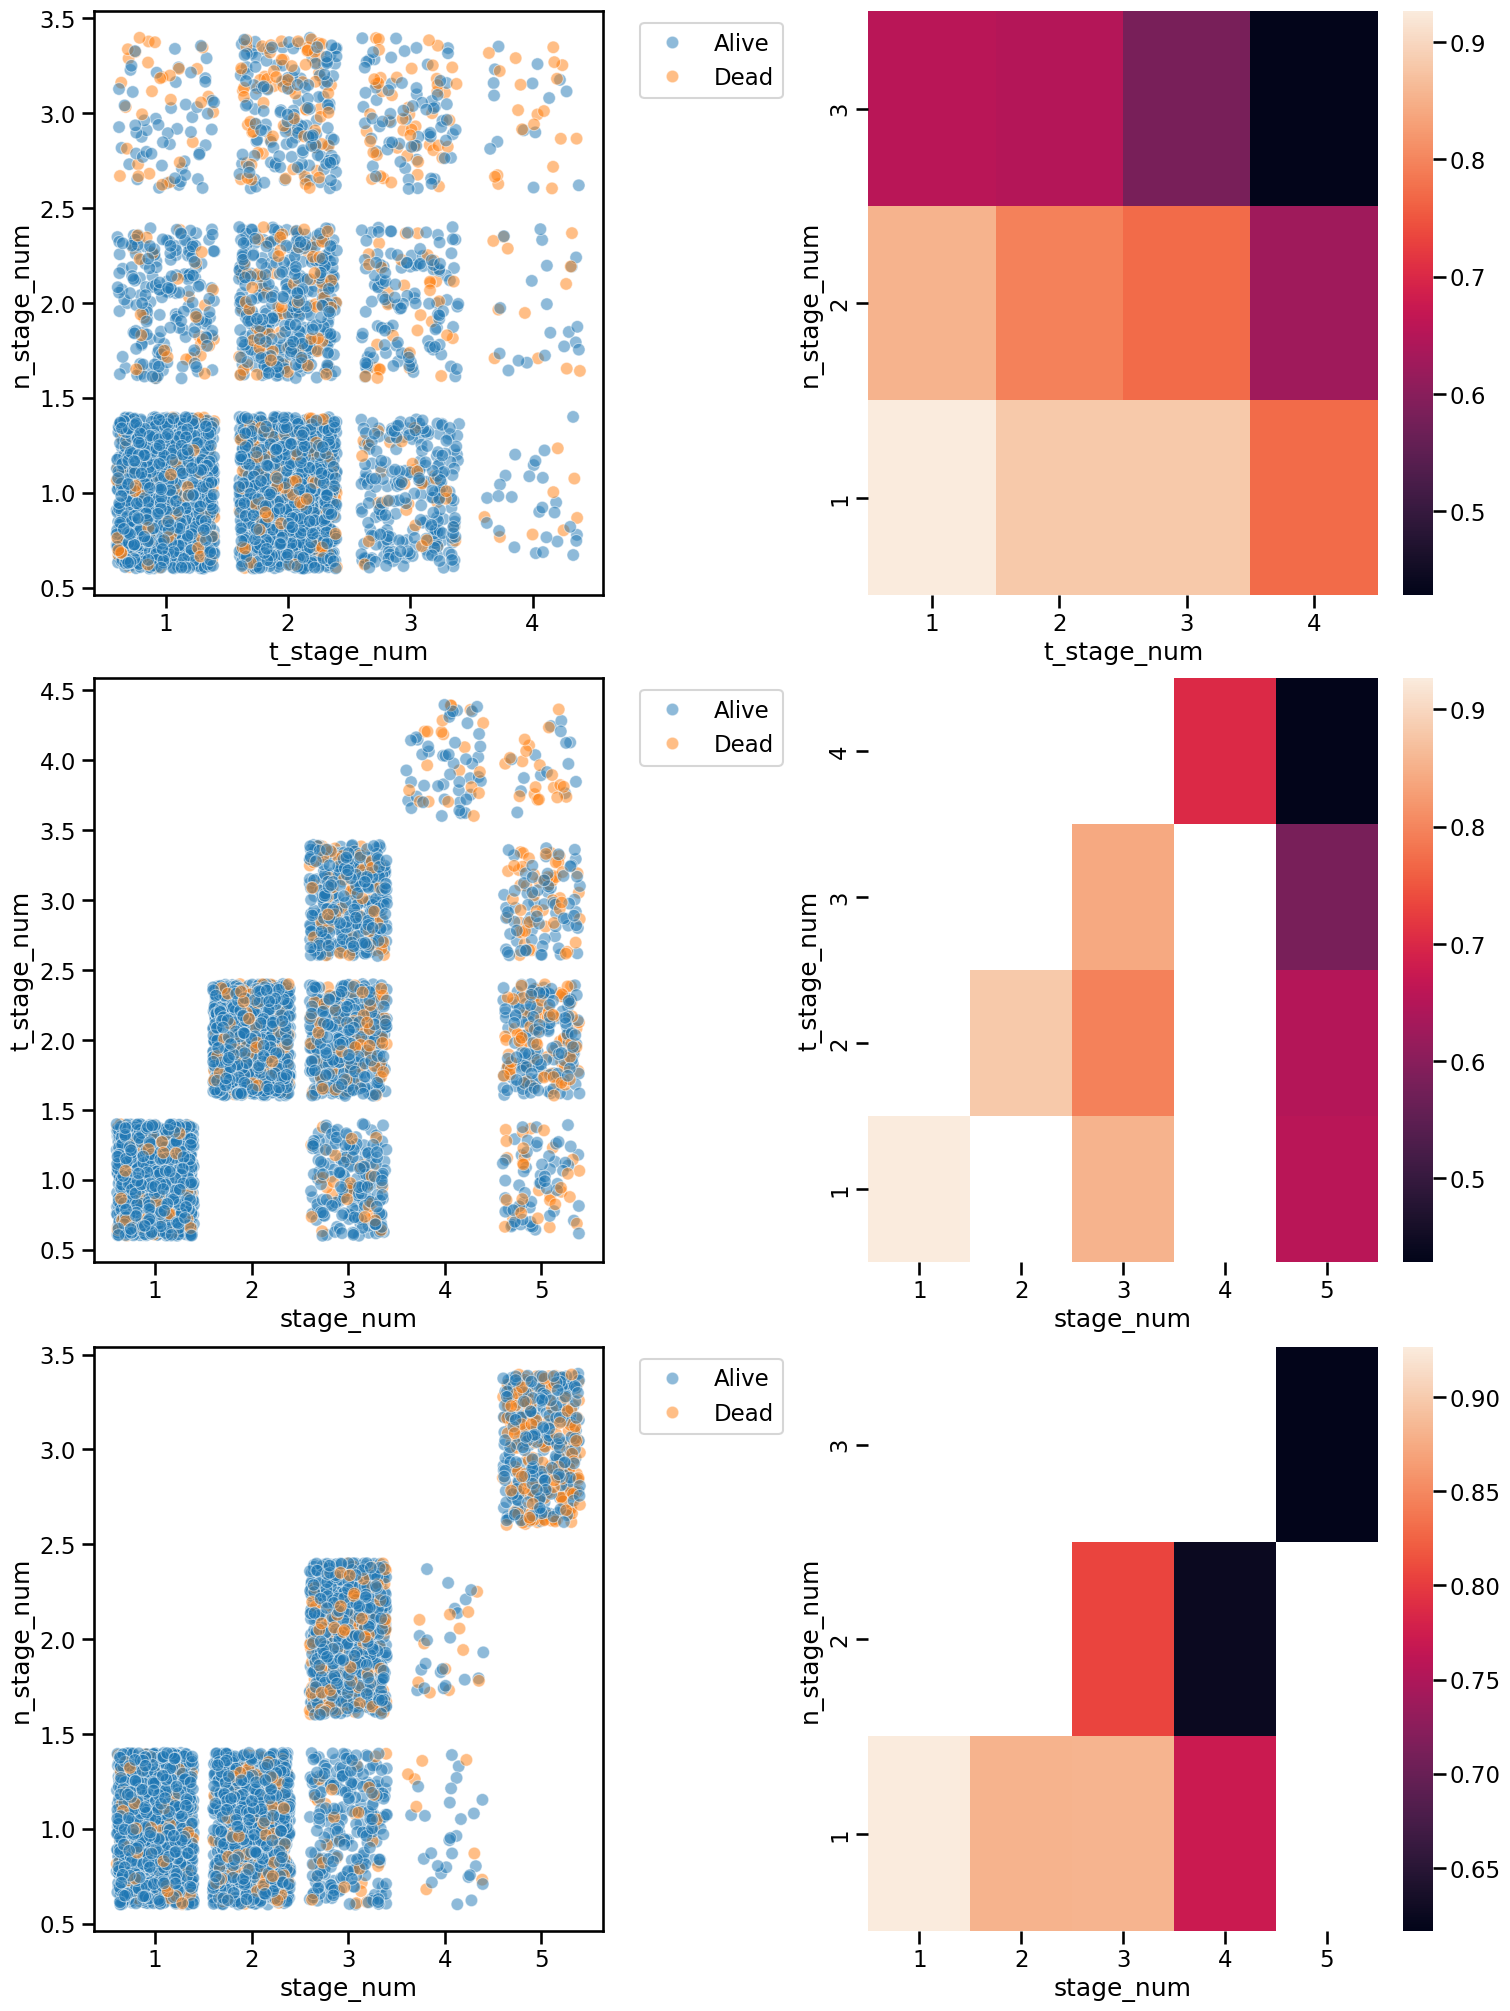

In [50]:
pairs = [
    ("t_stage_num", "n_stage_num"),
    ("stage_num", "t_stage_num"),
    ("stage_num", "n_stage_num"),
]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 20), constrained_layout=True)
for ii, pair in enumerate(pairs):
    print(pair)
    jitter_plot(df, x_col=pair[0], y_col=pair[1], ax=ax[ii, 0])
    pivot_to_heat_map(df, columns=pair[0], index=pair[1], ax=ax[ii, 1], margins=False)
    ax[ii, 1].invert_yaxis()

**Notes:** 

Similar to the correlation plots above, stage number, n stage num and t stage num are highly correlated and related to the survival rate. In general, the higher each of these features are, the lower the survival rate (heat map,darker)

<Axes: xlabel='has_estrogen', ylabel='is_alive'>

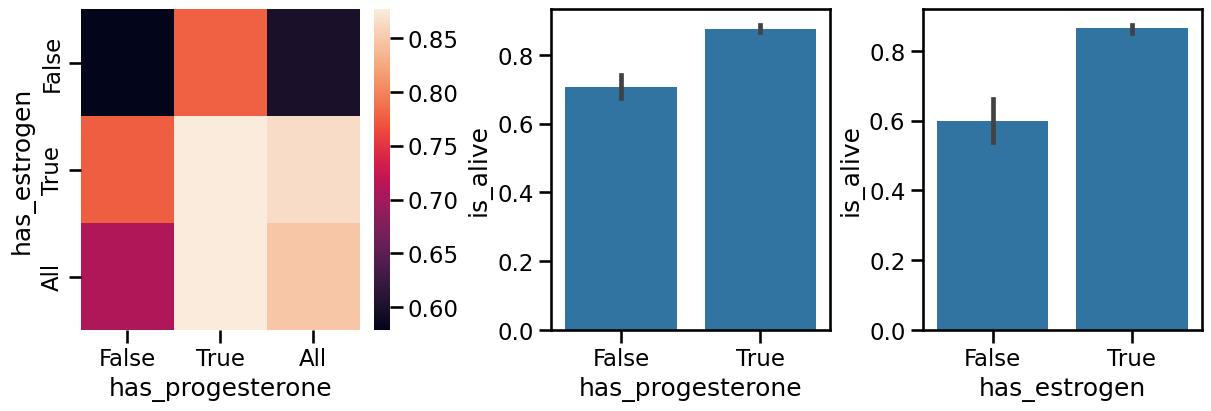

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

pivot_to_heat_map(
    df, "has_progesterone", "has_estrogen", values="is_alive", margins=True, ax=ax[0]
)

sns.barplot(data=df, x="has_progesterone", y="is_alive", ax=ax[1])
sns.barplot(data=df, x="has_estrogen", y="is_alive", ax=ax[2])

**Notes:**
* Tumors with progestrone or estrogen appear to have higher survival rates. Perhaps this is due to the ability to target these receptors with certain drugs.

In [51]:
def generate_cat_vs_numeric(df, x, y, violin_inner="stick"):

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

    sns.stripplot(data=df, x=x, y=y, ax=ax[0])
    sns.boxplot(data=df, x=x, y=y, ax=ax[1])
    sns.violinplot(data=df, x=x, y=y, inner=violin_inner, ax=ax[2])

    return None

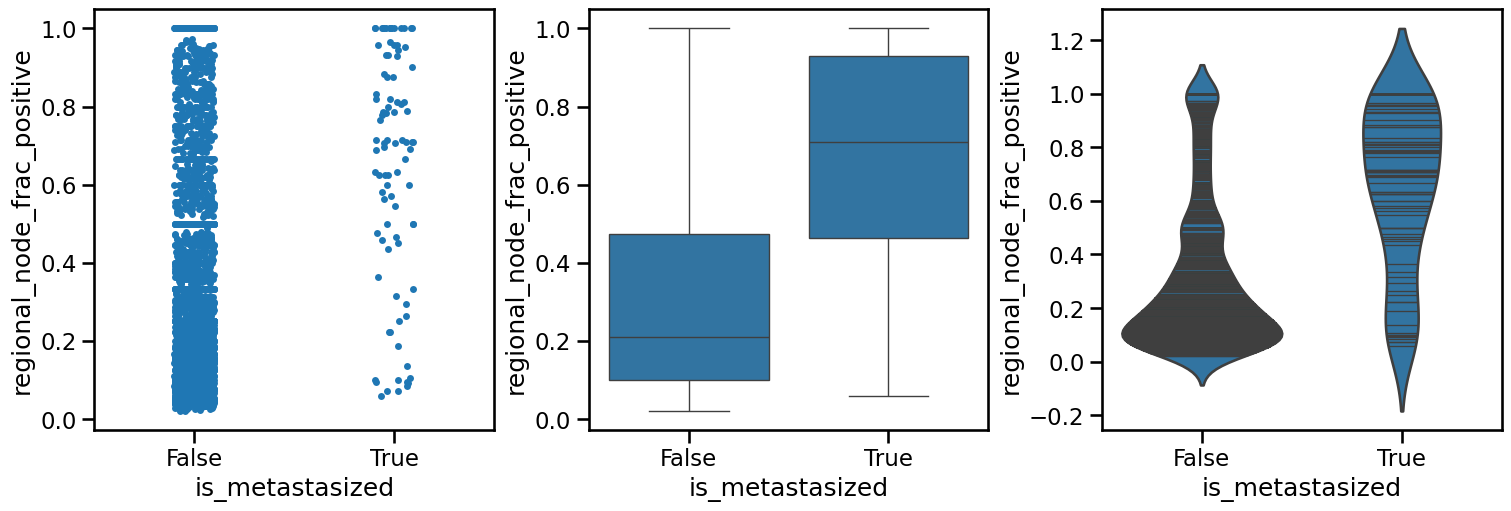

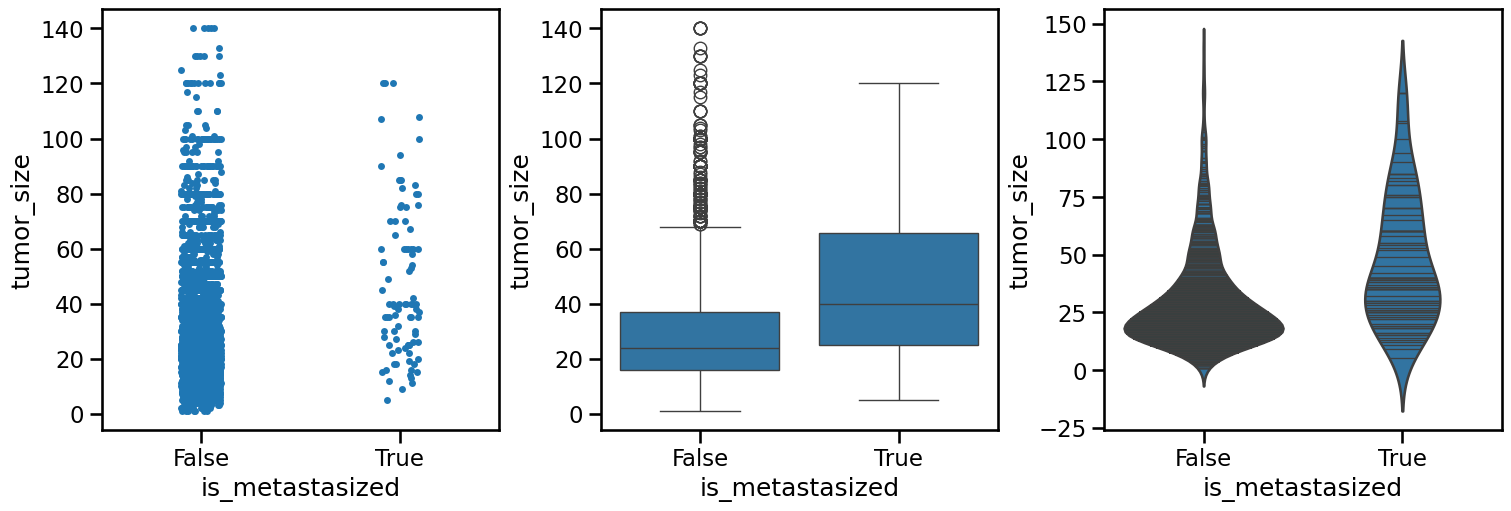

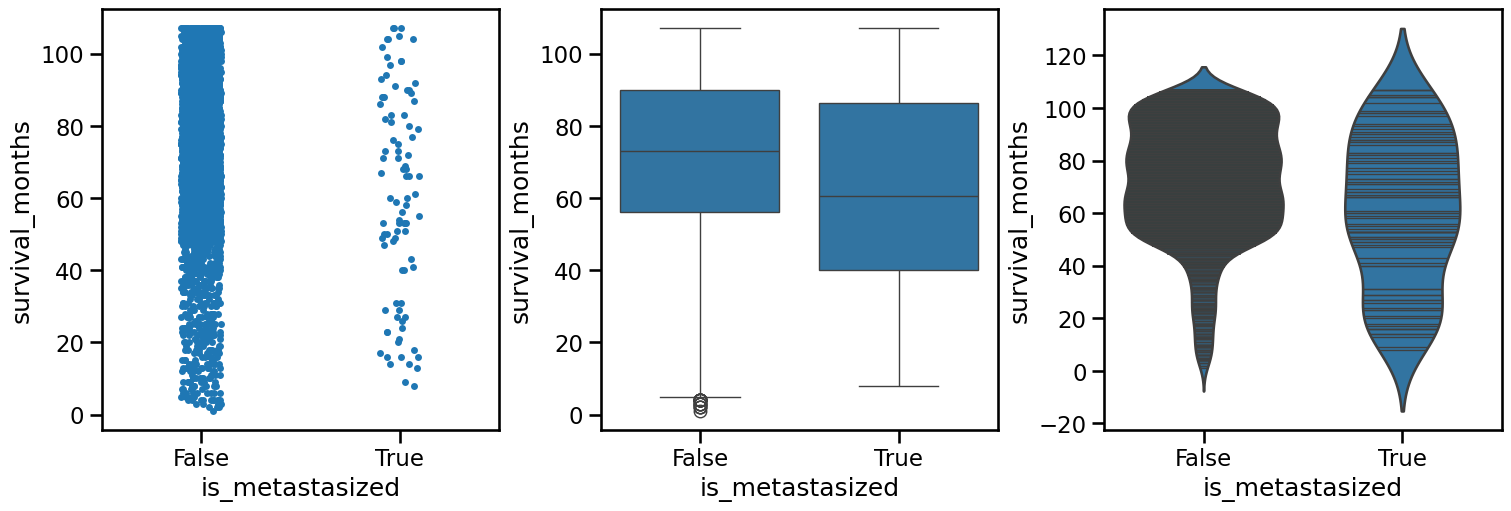

In [55]:
generate_cat_vs_numeric(df, x="is_metastasized", y="regional_node_frac_positive")
generate_cat_vs_numeric(df, x="is_metastasized", y="tumor_size")
generate_cat_vs_numeric(df, x="is_metastasized", y="survival_months")

**Is metastasized notes**: 
* Metastasized patients have a higher fraction of positive regional nodes
* Metastasized patients have a larger tumor size
* Metastasized patients have a slightly shorter survival time

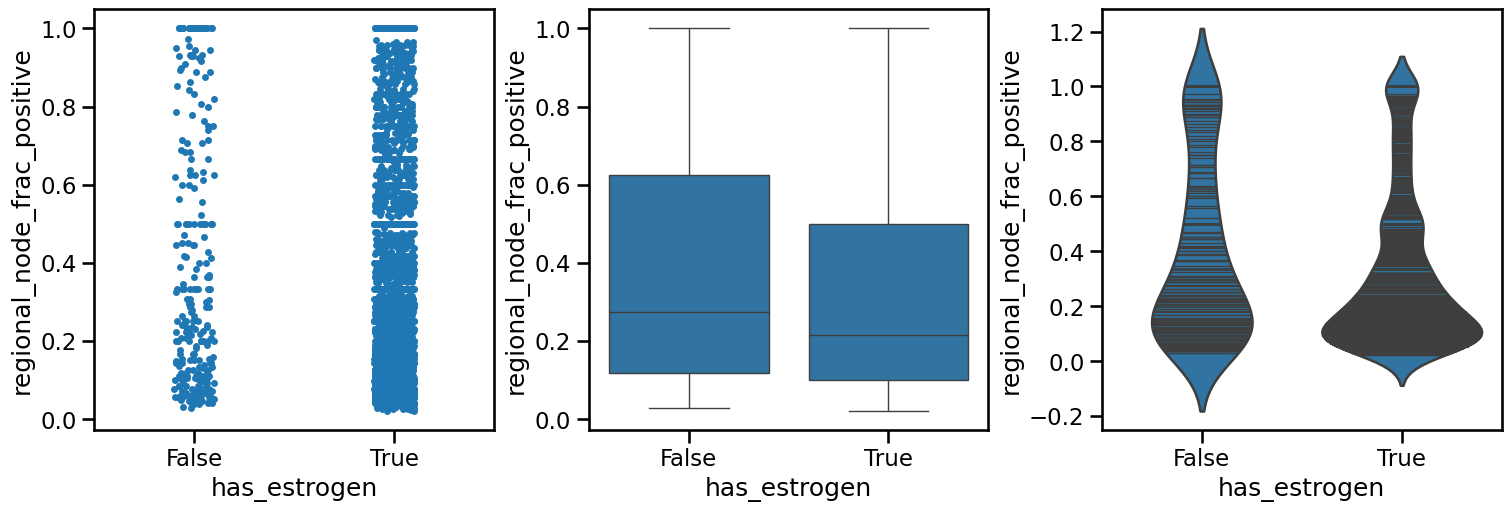

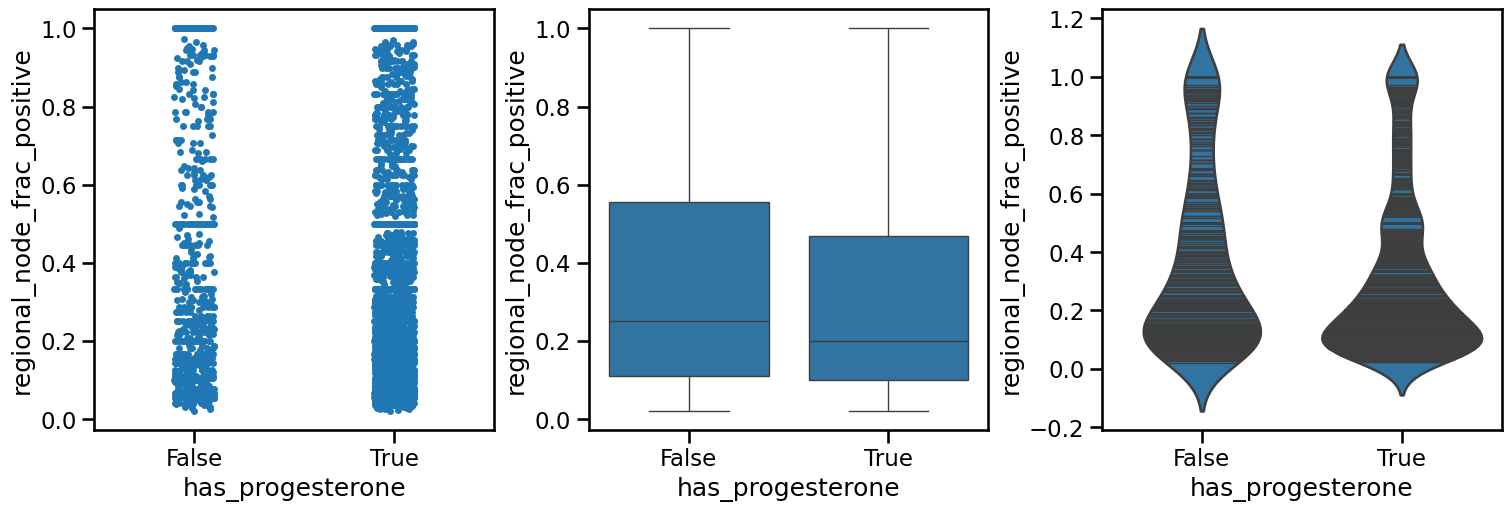

In [81]:
generate_cat_vs_numeric(df, x="has_estrogen", y="regional_node_frac_positive")
generate_cat_vs_numeric(df, x="has_progesterone", y="regional_node_frac_positive")

It appears that tumors with progestrone and/or estrogren have a slightly lower number of regional nodes that are positive. This makes sense given these features also have higher survival rates. It's unclear what the causal direction would be here though.

# TODO Survival Months
- distribution
- P(survival over time)

# Extra

In [19]:
def example_plot_histogram(df, x_val, ax=None, title="", **kwargs):
    """
    Example function to plot a histogram using seaborn

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing the data to plot
    x_val : str
        Name of the column to plot
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, by default None
    title : str, optional
        Title of the plot, by default ""
    **kwargs : dict
        Additional arguments to pass to seaborn.histplot,
        e.g. hue="var_name", ="stack"

    Returns
    -------
    matplotlib.axes.Axes
        Axes containing the plot
    """
    if ax is None:
        ax = mf()

    sns.histplot(data=df, x=x_val, ax=ax, **kwargs)

    ax.set_title(title)

    return ax

<Axes: xlabel='age', ylabel='Count'>

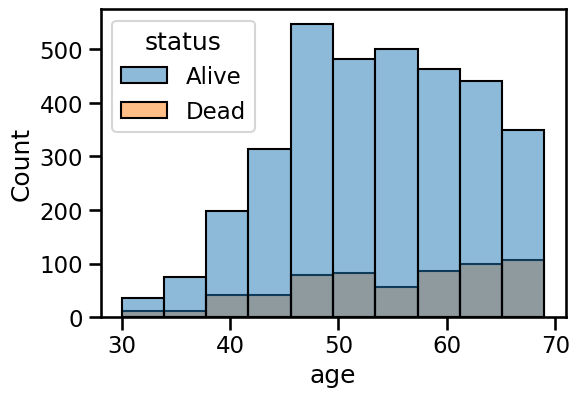

In [24]:
example_plot_histogram(df, x_val="age", hue="status", bins=10)

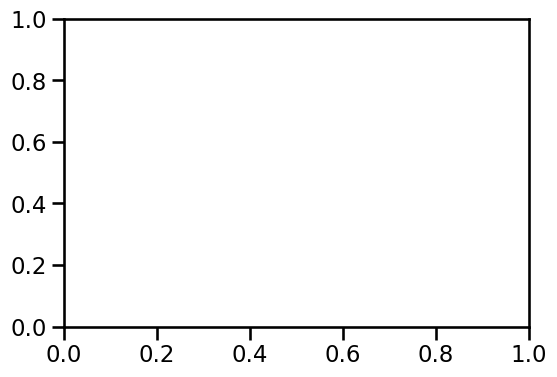

In [5]:
ax = mf((6, 4))  # mf = "make figure" from plot utils